# Residual Networks (ResNet) and RexNeXt

As we design deeper networks, imperative to understand how to ensure that this depth actually adds expressivness instead of just arbitrary complexity.

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Function Classes

There's no point adding arbitrary complexity to models if you can't be sure that that complexity is being added in such a way that it improves on the expressiveness of the model. Ideally, if trying to fit an arbitrary function f(x), each layer should get us closer to that true function so that if a first layer fits a function g(x), the next only has to fit g'(x) = f(x) - g(x) (and so on).

## Residual Blocks

Residual blocks facilitate this by short circuiting the input of a function to the output. 

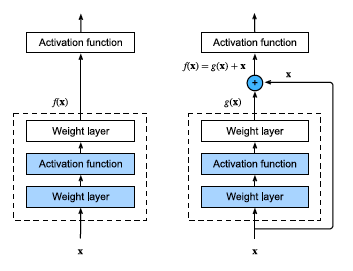

^ A residual block on the right, and a regular block with inputs to an activation function on the left. 

The block on the left must learn the entire function $f(x)$, while the block on the right needs only to learn the _residual mapping_, $g(x) = f(x) - x$. This represents the residual block of ResNet, where the solid line on the right represents the residual connection (or shortcut connection) to the output. ResNet has VGGs full 3x3 convolutional layer design. The residual block itself has two 3x3 convolutional layers, and each convolutional layer is followed by a batch normalization layer, then ReLU. This design requires that the input and output have the same shape, so that they can be added together with the residual connection, if we wish to change the number of channels, we must add a 1x1 convolution to achieve this. 

The Resdiual class below specifies two different types of netoworks, one in which the residual connection is made directly, and one in which we adjust the number of channels before outputting. 

In [7]:
class Residual(nn.Module):
    """A residual block"""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)

        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)

        Y += X
        return F.relu(Y)

In [9]:
# Usage while keeping input and output dimensions the same shape
blk = Residual(3)
X = torch.randn(
    4, # examples
    3, # Channelx
    6, # height
    6 # Width
)

blk(X).shape

torch.Size([4, 3, 6, 6])

In [10]:
# Usage while reducing the number of input dimensions and adding channels
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## The ResNet Model

The first two layers of ResNet are the same as those of GoogLeNet, the 7x7 convolutional layer with 64 output channels and a stride of 2. This is is followed by a 3x3 max-pooling layer with a stride of 2. Howeever, ResNet includes batch normalization after each convolutional layer. 

Where GoogLeNet uses four modules made up of inception block, ResNet instead uses four modules made up of residual blocks (each using several residual blocks). After the first module, the height and width are halved in order to double the number of channel dimensions. 

Adding all the blocks together, we add a final mdoule which consists of a global average pooling, followed by a fully connected layer with the number of outputs as the number of classes.

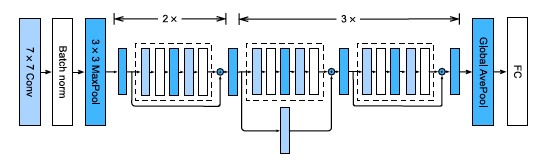

^ The ResNet-18 architecture

In [14]:
class ResNet(d2l.Classifier):

    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(
                f"b{i+2}", 
                self.block(*b, first_block=(i==0))
            )

        self.net.add_module(
            "last", 
            nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.LazyLinear(num_classes)
            )
        )

        self.net.apply(d2l.init_cnn)
    
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

In [15]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(
            (
                (2, 64), (2, 128), (2, 256), (2, 512)
            ),
            lr, 
            num_classes
        )

In [16]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## training

In [18]:
model = ResNet18(lr=0.01)

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], d2l.init_cnn)

if torch.cuda.is_available():
    trainer.fit(model, data)
    
    # Save the parameters since this is expensive
    name = model.__class__.__name__ + "-" + data.__class__.__name__ + "-" + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + ".pt"
    torch.save(model.state_dict(), name)
else: 
    print("You're not training this without a GPU. If you really wanna, you can remove this check")

You're not training this without a GPU. If you really wanna, you can remove this check


## ResNeXt

ResNeXt allows for more nonlinearity within a given block by applying parallel convolutions which are then concatenated together in a final step. Breaking one large convolution up into g parallel convolutions makes the proccess g times faster, while still allowing for nonlinearity. Information is transferred among the separate 3x3 convolutions by way of 1x1 convolutions on either side of the branching operations. This prevents the convolutions from simply learning the same features/transforms. 

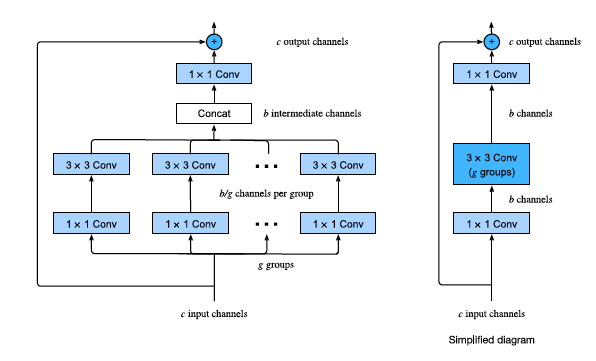

^ The ResNeXt block

In [21]:
class ResNeXtBlock(nn.Module):
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))

        # first convolution, 1x1 sandwich
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)

        # g groups of convolutions which are spatially resolved
        self.conv2 = nn.LazyConv2d(
            bot_channels, 
            kernel_size=3,
            stride=strides, 
            padding=1, 
            groups=bot_channels // groups
        )

        # Final 1x1 convolution
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)

        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()

        # Used in cases where the residual connection has a 1x1 convolution
        # I..e if we want the block to change the number of channels
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
            stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

## Summary And Discussion

Nested function classes are highly desirable, they allow us to be certain that we are making strictly _more powerful_ rather than simply _subtly different_ networks when adding complexity. Residual networks achieve this simply by passing the input through to the output, so that the network learns the residual function mapping. 

This allows us to train deeper networks more easily, the original resnet paper allowed for up to 152 layers. It also allows us to add layers _during_ the training process, after all, the default behaviour of a layer is just to pass the data through with the identity function. The residual connection idea is key to the transformer architecture. 